In [31]:
%matplotlib inline

import sys
import os
import io
import pathlib
import requests
import json

import pandas
from matplotlib import pyplot

from tom_client import TomClient

In [2]:
# Must pass either password= or passwordfile= to the TomClient constructor.
# Don't save passwords to any git archive!
tomuser = 'rknop'
tompasswd = None
tompasswdfile = pathlib.Path( os.getenv( "HOME" ) ) / "secrets/tom_rknop_passwd"

tom = TomClient( username=tomuser, password=tompasswd, passwordfile=tompasswdfile )

In [3]:
# Load in all the classids and classifiers for reference
res = tom.request( page="elasticc2/classids" )
classids = res.json()
res = tom.request( page="elasticc2/classifiers_json" )
classifiers = res.json()

## Getting broker classification summary info

The main URL to get the data on broker performance is:
```
  elasticc2/brokerclassfortruetype/format/what/classifier_id/classid
```

where `what` is what you want (see below), `classifier_id` is the numeric classifier id (look in the `classifiers` variable loaded above), and `classid` is the numeric id of the true class (look in the `classids` variable loaded above).

The queries that load this information from the database are slow, as is the post-processing of those queries, so I've run them ahead of time and they're cached in files on the server; this URL just returns the contents of those files.  Of course, they only include information up through when they were last generated, but once ELAsTiCC2 is over, I'll run it a final time so we have the final summary information.

What you get back depends on the value of format.  If format is `dict`, you a dictionary with three elements: `index` tells you what the returned data is indexed by, `columns` tells you what columns are in the returned data, and `data` has the returned data. `data` is a nested dictionary; each level of the dictionary has keys that correspond to one of the elements in the `indexes`.  The lowest-level dictionary has a value that is an array with the values that correspond to the elements in `columns`.  (This is more or less what you get when you call `pandas.DataFrame.to_dict(orient='split')`.

If format is `pickle`, you get a binary blob that is a pickled pandas DataFrame. If you're lucky, you can stick this into a `BytesIO` object and use `Pandas.read_pickle` to restore it.

what can be one of:
* `objects`
* `sources`
* `classifications`
* `meanprobabilities`
* `maxprobabilities`

The first two return basic information about the objects and sources that have been classified by this classifier, including some truth info, but without any broker classification information.

`classifications` is BIG, and returns every classification that this broker made for every object that had the indicated true type.  This is the one you have to get if you want to do your own post-processing and aggregation.  But, be aware that you're going to have to pull down and then process gigabytes of data if you ask for this... and that's just for a single classifier and a single true type!  What yo u

`meanprobabilities` and `maxprobabilities` are the ones you're probably going to want to use the most; they're the fastest, because things have already been aggregated.  Both return data structures that are a function of predicted class and "relday" (which is day relative to the peak of the lightcurve, binned in 1-day intervals from -20 to 90 days relative to peak (can you tell I'm a Ia person?)).

`meanprobabilities` returns the mean of all probabilities for each predicted class for every classified point that fell in each time bin.

`maxproabilities` is ill-considered and I need to fix it.

In [4]:
# For example: let's do classifier 13 (ALeRCE TinyWinyClassifier 1.1.0) and true class 2222 (SN Ia)
cfer = 13
truetype = 2222


In [7]:
# You'll notice that the sources query here is kind of slow
# The classifications query would be MUCH slower.  This could
# probably be faster if I made a serivce that returned
# pickled panadas DataFrames.

for what in ( 'objects', 'sources', 'maxprobabilities', 'meanprobabilities' ):
    res = tom.request( page=f"elasticc2/brokerclassfortruetype/dict/{what}/{cfer}/{truetype}" )
    info = res.json()
    print( f"Nested dictionary keys: {info['index']}" )
    print( f"Data in lowest-level dictionary: {info['columns']}" )
    print( f"There are {len(info['data'])} values of {info['index'][0]}" )
    
# Show the "meanprobabilities" dictionary
# info

<Response [200]>
Nested dictionary keys: ['s.diaobject_id']
Data in lowest-level dictionary: ['t.zcmb', 't.peakmjd', 't.gentype']
There are 1097301 values of s.diaobject_id
<Response [200]>
Nested dictionary keys: ['s.diasource_id']
Data in lowest-level dictionary: ['s.diaobject_id', 's.midpointtai', 'deltat', 'relday', 's.filtername', 's.psflux', 's.snr']
There are 7021433 values of s.diasource_id
<Response [200]>
Nested dictionary keys: ['relday']
Data in lowest-level dictionary: classid
There are 111 values of relday
<Response [200]>
Nested dictionary keys: ['relday', 'm.classid']
Data in lowest-level dictionary: ['m.probability']
There are 111 values of relday


In [47]:
skip_the_slow_thing = True

In [48]:
# Faster is just pulling down the binary panads pickles and restoring them.
# Let's go nuts and pull down the giant one.  This still takes a while.

if not skip_the_slow_thing:
    res = tom.request( page=f"elasticc2/brokerclassfortruetype/pickle/classifications/{cfer}/{truetype}" )

In [49]:
if not skip_the_slow_thing:
    bio = io.BytesIO( res.content )
    df = pandas.read_pickle( bio )
    df

In [50]:
if not skip_the_slow_thing:
    print( f"Read a {len(df):,}-row dataframe from {len(res.content)/1024/1024:.3f} MiB of returned data" ) 

In [51]:
# OK, let's work with the mean probabilities, because that one has a manageable size,
# and has already done the a very useful aggregation.

res = tom.request( page=f"elasticc2/brokerclassfortruetype/pickle/meanprobabilities/{cfer}/{truetype}" )
bio = io.BytesIO( res.content )
meanprobdf = pandas.read_pickle( bio )
meanprobdf

m.probability
relday m.classid               
-20    100             0.000000
       200             0.000000
       300             0.000000
       1100            0.000000
       2100            0.000000
...                         ...
 90    2324            0.000001
       2325            0.000002
       2326            0.000000
       2331            0.000000
       2332            0.003499

[3552 rows x 1 columns]

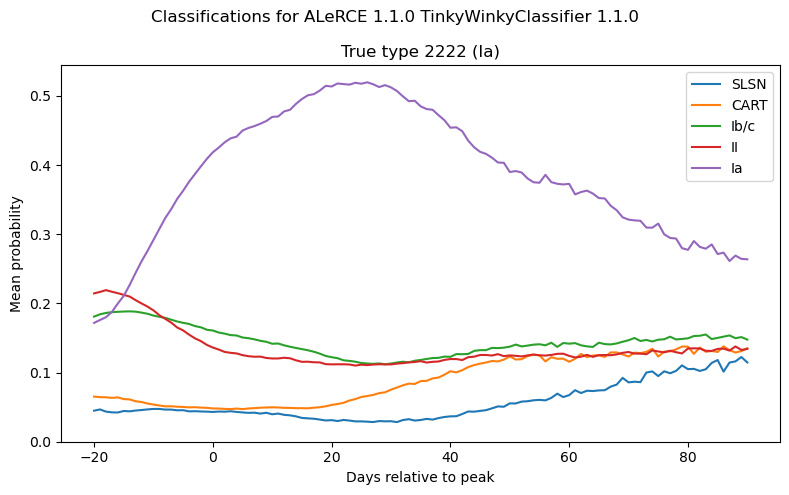

In [52]:
# Let's find the five most probable classes at any time, and plot the probabilities of those
#  classes as a function of time.
s = meanprobdf.sort_values( 'm.probability' ).reset_index().groupby( 'm.classid' ).agg( 'last' ).sort_values( 'm.probability' )
classestodo = s.index.values[ -5: ]

fig = pyplot.figure( figsize=(8,5), layout='tight' )
c = classifiers[ str(cfer) ]
fig.suptitle( f"Classifications for {c['brokername']} {c['brokerversion']} {c['classifiername']} {c['classifierparams']}" )
ax = fig.add_subplot( 1, 1, 1 )
ax.set_title( f"True type 2222 ({classids[str(truetype)]['description']})" )
for classid in classestodo:
    subdf = meanprobdf.xs( classid, level='m.classid' )
    ax.plot( subdf.index.values, subdf['m.probability'].values, label=classids[str(classid)]['description'] )
    ax.set_xlabel( "Days relative to peak" )
    ax.set_ylabel( "Mean probability" )
ax.set_ylim( [ 0, ax.get_ylim()[1] ] )
ax.legend()
fig.show()